# Chap06 - 게이트가 추가된 RNN

> [Chap05-순환신경망(RNN)](https://github.com/ExcelsiorCJH/DLFromScratch2/blob/master/Chap05-Recurrent_Neural_Network/notebook.ipynb)에서 살펴본 RNN 구조는 순환경로를 통해 과거의 정보를 기억할 수 있었다. 하지만, 실제로는 성능이 좋지 못한데 그 이유는 장기(long term)의존 관계를 잘 학습할 수 없기 때문이다.  이번 장에서는 이러한 RNN의 단점을 보완한 LSTM, GRU에 대해서 다룬다. LSTM이나 GRU에는 **'게이트'**(gate)라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다.

## 6.1 RNN의 문제점

- RNN의 문제점은 시계열 데이터의 장기 의존 관계(long-term dependency)를 학습하기 어렵다.

- 그 원인은 BPTT에서 기울기 소실 또는 기울기 폭발(vanishing & exploding gradient)이 일어나기 때문이다.

### 6.1.1 RNN 복습

<img src="./images/fig_6-1.png" height="70%" width="70%" />

- RNN 계층은 시계열 데이터인 $\mathbf{x}_{t}$를 입력하면 $\mathbf{h}_{t}$를 출력한다. 

- $\mathbf{h}_{t}$는 RNN 계층의 **은닉 상태(hidden state)**라고 하며, 과거 정보를 저장하는 역할을 한다.

- RNN cell의 내부를 자세히 살펴보면 아래의 그림과 같다.

<img src="./images/fig_6-2.png" height="50%" width="50%" />

### 6.1.2 기울기 소실 또는 기울기 폭발

<img src="./images/fig_6-3.png" height="70%" width="70%" />

- 위의 예시에서 `"?"`에 들어가는 단어는 "Tom"이다. 

- RNNLM이 이 문제에 올바르게 답하려면, "Tom was watching TV in his room."과  "Mary came into the room."이라는 정보를 기억해둬야 한다.

- 즉, 이러한 정보를 RNN 레이어의 hidden state에 인코딩해 보관해둬야 한다.

- 위의 예시에 대한 RNNLM의 BPTT는 아래의 그림과 같다.

<img src="./images/fig_6-4.png" height="60%" width="60%" />

- 위의 그림에서 RNN 레이어가 과거 방향으로 기울기(gradient)를 전달함으로써 시간 방향의 의존관계를 학습할 수 있게 된다.

- 이때의 기울기는 (이론적으로) 학습해야 할 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다.

- 하지만, 단순한 RNN(vanilla RNN) 레이어에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 커지는 문제가 발생한다(vanishing or exploding gradient).

### 6.1.3 기울기 소실과 기울기 폭발의 원인

<img src="./images/fig_6-5.png" height="70%" width="70%" />

- 위의 그림은 길이가 $T$인 시계열 데이터를 가정하여 $T$번째 정답 레이블로부터 전해지는 기울기가 어떻게 변화하는지 나타낸 그림이다.

- 이때, 시간 방향 기울기(gradient)를 살펴보면, 역전파로 전해지는 기울기는 차례로 `'tanh'` → `'+'` → `'MatMul'` 연산을 통과한다. 

- `'+'`의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보내기 때문에 기울기의 값이 변하지 않지만, `'tanh'`와 `'MatMul'`은 변하게 된다.

#### tanh의 역전파

$$
y = \tanh{(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

$$
\begin{align*}
\frac{\partial \tanh{(x)}}{\partial x} &= \frac{( e^x + e^{-x})(e^x + e^{-x}) - ( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \frac{( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \left\{ \frac{( e^x - e^{-x})}{( e^x + e^{-x})} \right\}^{2} \\
&= 1 - \tanh{(x)}^{2} \\
&= 1-y^{2}
\end{align*}
$$

<img src="./images/fig_6-6.png" height="40%" width="40%" />

- 위의 그래프에서 점선이 $y=\tanh{(x)}$의 미분이며, 그 값이 1.0 이하이고, $x$가 0으로 부터 멀어질수록 작아진다. 

- 따라서, 역전파에서 기울기가 $\tanh$ 노드를 지날때 마다 값은 계속해서 작아지게 된다. 

#### MatMul에서의 역전파

<img src="./images/fig_6-7.png" height="70%" width="70%" />

- 상류로부터 흘러온 기울기 $\mathbf{dh}$ `'MatMul'`노드에서의 역전파는 $\mathbf{dh} \cdot \mathbf{W_h}^{\mathsf{T}}$라는 행렬 곱이 된다.

- 이러한 행렬곱이 시계열 데이터의 time_step 만큼 반복한다. 

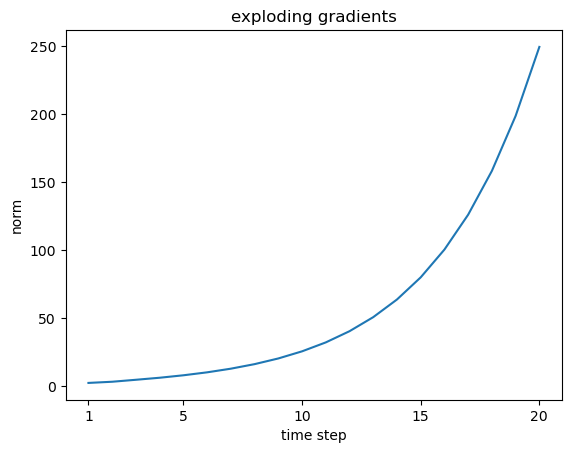

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = 2  # 미니배치 크기
H = 3  # hidden state 벡터의 차원 수
T = 20  # 시계열 데이터의 길이(= timestep)

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) # 기울기 소실

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
u, s, vh = np.linalg.svd(Wh)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.title('exploding gradients')
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

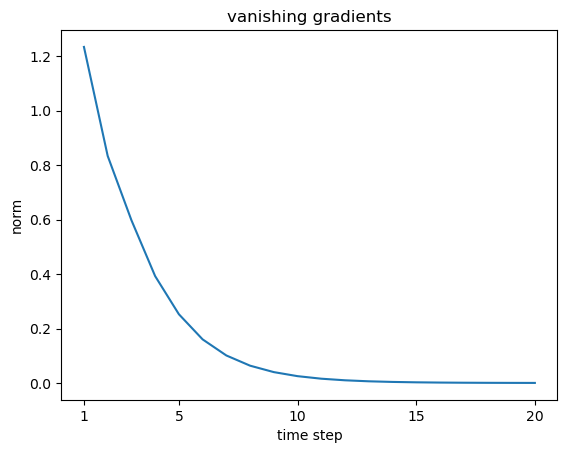

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = 2  # 미니배치 크기
H = 3  # hidden state 벡터의 차원 수
T = 20  # 시계열 데이터의 길이(= timestep)

dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
u, s, vh = np.linalg.svd(Wh)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.title('vanishing gradients')
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

### 6.1.4 기울기 폭발 대책

- 기울기 폭발(exploding gradient) 해결책으로는 **기울기 클리핑(gradients clipping)**이라는 기법이 있다.

- 기울기 클리핑 알고리즘을 의사코드로 나타내면 다음과 같다.

$$
\text{if } \left\| \hat{g} \right\| \ge threshold:
$$

$$
\hat{g} = \frac{threshold}{\left\| \hat{g} \right\|} \hat{g}
$$

- 위의 식에서 $\hat{g}$는 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것이다.
    - 예를 들어, $\mathbf{W}_{1}$과 $\mathbf{W}_{2}$ 매개변수에 대한 기울기 $\mathbf{dW}_{1}$과 $\mathbf{dW}_{2}$를 결합(제곱의 합)한 것이다.
    

- 위의 식에서 $\left\| \hat{g} \right\|$(기울기 L2 노름)가 $threshold$ 값을 초과하면 두 번째 수식과 같이 기울기를 수정한다. 

In [5]:
# chap06/clip_grads.py
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0  # threshold

def clip_grads(grds, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [6]:
print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [2.77977507 4.54622076 2.05410345 2.01378711 5.1403506  0.87229369
 4.83585532 3.62176212 7.07686622]
after: [0.66651711 1.09006443 0.4925201  0.4828533  1.23252117 0.20915313
 1.15951119 0.86840351 1.69684679]


## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

- 아래의 그림과 같이 $\tanh{\left( \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}} + \mathbf{x}_{t} \mathbf{W}_{\mathbf{x}} + \mathbf{b} \right)}$ 를 `tanh`노드로 나타내어 간소화한 것이다.

<img src="./images/fig_6-10.png" height="70%" width="70%" />

- RNN Cell과 LSTM Cell을 간단하게 비교하면 아래의 그림처럼 나타낼 수 있다.

<img src="./images/fig_6-11.png" height="70%" width="70%" />

- 위의 그림에서 보듯 LSTM 계층에는 $\mathbf{c}$라는 경로가 있다는 것이 RNN과의 차이다. 

- $\mathbf{c}$를 **기억 셀**(memory cell)이라고 하며, LSTM의 기억 메커니즘이다.

- memory cell의 특징은 LSTM 계층 내에서만 주고받는다는 것이다.
    - 다른 계층으로는 출력하지 않는다. 

### 6.2.2 LSTM 계층 조립하기

- $\mathbf{c}_{t}$에는 timestep $t$에서의 LSTM의 기억이 저장되어 있는데, 과거로 부터 $t$까지에 필요한 모든 정보가 저장되어 있다고 가정한다.

- 이러한 기억 $\mathbf{c}_{t}$를 바탕으로 특정 연산을 거친 후 외부 계층과 다음 timestep $t+1$의 LSTM에 hidden state $\mathbf{h}_{t}$를 출력한다. 
     - 이때 출력하는 $\mathbf{h}_{t}$는 아래의 그림처럼 memory cell $\mathbf{c}_{t}$의 값을 $\tanh$ 함수로 변환한 값이다.

<img src="./images/fig_6-12.png" height="60%" width="60%" />

- memory cell $\mathbf{c}_{t}$와 hidden state $\mathbf{h}_{t}$의 관계는 $\mathbf{c}_{t}$의 각 원소에 $\tanh$ 함수를 적용한 것이다. 

- 즉, $\mathbf{c}_{t}$와 $\mathbf{h}_{t}$의 원소수는 같다는 뜻이고, 예를 들어, $\mathbf{c}_{t}$의 원소 수가 100개면 $\mathbf{h}_{t}$의 원소 수도 100개가 된다.

#### 게이트(gate)의 개념

- 게이트는 **데이터의 흐름**을 **제어(control)**하는 역할을 한다.

- 아래의 그림처럼 게이트의 열림 상태는 `0.0 ~ 1.0` 사이의 실수로 나타나며, '게이트를 얼마나 열까'라는 것도 데이터로 부터 (자동으로) 학습 한다.

- 게이트의 열림 상태를 구할 때는 `sigmoid` 함수를 사용하는데, `sigmoid`함수의 출력이 0.0 ~ 1.0의 실수이기 떄문이다.

<img src="./images/fig_6-14.png" height="60%" width="60%" />

#### LSTM의 게이트들

<img src="./images/lstm.PNG" height="80%" width="80%" />

### 6.2.3 output 게이트


- output 게이트는 hidde state($\mathbf{h}_{t}$)의 출력을 담당한다.

- output 게이트는 $\tanh{(\mathbf{c}_{t})}$의 각 원소에 대해 '그것이 다음 timestep의 hidde state($\mathbf{h}_{t}$)에 얼마나 중요한가'를 제어한다.

- output 게이트의 열림 상태는 입력 $\mathbf{x}_{t}$와 이전 상태 $\mathbf{h}_{t-1}$로 부터 구한다. 아래의 식에서 $\sigma {()}$는 시그모이드 함수를 의미한다.


$$
\mathbf{o} = \sigma \left( \mathbf{x}_{t}\mathbf{W}_{\mathbf{x}}^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(o)} + \mathbf{b}^{(o)} \right)
$$

<img src="./images/fig_6-15.png" height="60%" width="60%" />

- 위의 그림에서 output 게이트의 열림 상태를 계산한 $\mathbf{o}$는 $\tanh{\mathbf{c}_{t}}$의 원소별 곱(element-wise, point-wise, 또는 아다마르 곱)을 통해 $\mathbf{h}_{t}$를 구하게 된다.

$$
\mathbf{h}_{t} = \mathbf{o} \odot \tanh{(\mathbf{c}_{t})}
$$

> - $\tanh$의 출력은 `-1.0 ~ 1.0`의 실수이다. 이 `-1.0 ~ 1.0`의 수치를 그 안에 인코딩된 **'정보'**의 강약(정도)를 표시한다고 해석할 수 있다.
- 시그모이드 함수의 출력은 `0.0 ~ 1.0`의 실수이며, 데이터를 얼만큼 통과시킬지를 정하는 비율을 뜻한다.
- 따라서, 게이트에서는 시그모이드 함수가 사용되고, 실질적인 '정보'를 지니는 데이터에는 $\tanh$함수가 사용된다.

### 6.2.4 forget 게이트

- forget 게이트는 memory cell에 '무엇을 잊을지'를 제어하는 역할을 한다.

$$
\mathbf{f} = \sigma \left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{f})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{f})} + \mathbf{b}^{(\mathbf{f})} \right)
$$


- 위의 식에서 구한 $\mathbf{f}$와 이전 memory cell인 $\mathbf{c}_{t-1}$과의 원소별 곱, $\mathbf{c}_{t} = \mathbf{f} \odot \mathbf{c}_{t-1}$을 계산하여 $\mathbf{c}_{t}$를 구한다.

- forget 게이트를 LSTM 레이어에 추가하면 아래의 그림과 같다. 



<img src="./images/fig_6-16.png" height="60%" width="60%" />

### 6.2.5 새로운 기억 셀

- 6.2.4에서 forget 게이트를 통해 $t-1$ 시점의 memory cell로 부터 잊어야할 기억을 제어했다.

- 이번에는 memory cell에 새로 기억해야할 정보를 아래의 그림과 같이 `tanh` 노드를 추가해 준다.

- `tanh`노드가 계산한 결과를 이전 시각의 memory cell $\mathbf{c}_{t-1}$에 더해짐으로써 새로운 '정보'가 추가된다.

- 여기서 `tanh` 노드는 '게이트'가 아니며 단지 새로운 '정보'를 memory cell에 추가하는 것이 목적이다. 

$$
\mathbf{g} = \tanh{\left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{g})} + \mathbf{h}_{t-1} \mathbf{W}_{h}^{(\mathbf{g})} + \mathbf{b}^{(\mathbf{g})} \right)}
$$

- 위에서 계산한 $\mathbf{g}$(엄밀하게 말하면 $\mathbf{g}$를 제어하는 input 게이트 $\mathbf{i}$와의 원소 곱의 결과)가 이전 $t-1$ 시점의 $\mathbf{c}_{t-1}$에 더해짐으로써 새로운 기억이 생겨난다.

<img src="./images/fig_6-17.png" height="60%" width="60%" />

### 6.2.6 input 게이트

- input 게이트는 $\mathbf{g}$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단하는 역할을 한다.

- 즉, 새로운 정보($\mathbf{g}$)를 바로 더해주는 것이 아니라, input 게이트에 의해 가중된 정보가 새로 추가되는 것이다.

$$
\mathbf{i} = \sigma{\left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{i})} + \mathbf{h}_{t-1} \mathbf{W}_{h}^{(\mathbf{i})} + \mathbf{b}^{(\mathbf{i})} \right)}
$$

- 위에서 계산한 $\mathbf{i}$와 $\mathbf{g}$의 원소별 곱 결과를 memory cell에 더해준다.

<img src="./images/fig_6-18.png" height="60%" width="60%" />

### 6.2.7 LSTM의 기울기 흐름

<img src="./images/fig_6-19.png" height="60%" width="60%" />

- 위의 그림처럼, memory cell의 역전파에서는 '$+$'와 '$\times$' 노드만을 지나게 된다.

- '$+$' 노드는 상류에서 전해지는 기울기를 그대로 흘러보내기 때문에 기울기 변화(감소)는 일어나지 않는다.

- '$\times$' 노드는 '행렬 곱'이 아닌 '원소별 곱(아마다르 곱)'을 계산한다. 

- '행렬 곱'이 아닌 '원소별 곱'이 이뤄지고, 매 timestep 마다 다른 게이트 값을 이용해 원소별 곱을 계산한다.
    - 매번 새로운 게이트 값을 이용하기 때문에 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않게 되는 것이다.


- '$\times$' 노드의 계산은 forget 게이트가 제어한다. 
    - forget 게이트가 '잊어야 한다'(값이 0에 가까운 경우)고 판단한 memory cell의 원소에 대해서는 기울기가 작아진다.
    - forget 게이트가 '잊어서는 안된다' (값이 1에 가까운 경우)고 판단한 원소에 대해서는 기울기가 약화되지 않은채로 과거 방향으로 전해진다.

> LSTM은 Long Short-Term Memory의 약자이며, **단기 기억**(short-term memory)을 **긴**(lon)시간 지속할 수 있음을 의미한다.

## 6.3 LSTM 구현

$$
\begin{align*}
\mathbf{f} &= \sigma \left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{f})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{f})} + \mathbf{b}^{(\mathbf{f})} \right) \\
\mathbf{g} &= \tanh{\left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{g})} + \mathbf{h}_{t-1} \mathbf{W}_{h}^{(\mathbf{g})} + \mathbf{b}^{(\mathbf{g})} \right)}\\
\mathbf{i} &= \sigma{\left( \mathbf{x}_{t} \mathbf{W}_{x}^{(\mathbf{i})} + \mathbf{h}_{t-1} \mathbf{W}_{h}^{(\mathbf{i})} + \mathbf{b}^{(\mathbf{i})} \right)} \\
\mathbf{o} &= \sigma \left( \mathbf{x}_{t}\mathbf{W}_{\mathbf{x}}^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(o)} + \mathbf{b}^{(o)} \right)
\end{align*}
$$

$$
\mathbf{c}_{t} = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{g} \odot \mathbf{i}
$$

$$
\mathbf{h}_{t} = \mathbf{o} \odot \tanh{(\mathbf{c}_{t})}
$$

- 위의 식에서 $\mathbf{f}, \mathbf{g}, \mathbf{i}, \mathbf{o}$는 활성화 함수안에 아핀(affine)변환을 가지고 있다. 이 식을 아래의 그림처럼 하나의 식으로 정리해서 계산할 수 있다.

<img src="./images/fig_6-20.png" height="60%" width="60%" />

<img src="./images/fig_6-22.png" height="60%" width="60%" />

- LSTM 계산 그래프는 아래의 그림과 같다.

<img src="./images/fig_6-21.png" height="60%" width="60%" />

- 위의 그림에서 `slice` 노드의 순전파와 역전파는 아래의 그림과 같다.

<img src="./images/fig_6-23.png" height="60%" width="60%" />

In [1]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import *
from common.functions import sigmoid


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）  
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i  # Ct
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

### 6.3.1 Time LSTM 구현

<img src="./images/fig_6-24.png" height="60%" width="60%" />

<img src="./images/fig_6-25.png" height="60%" width="60%" />

In [2]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

In [3]:
# chap06/rnnlm.py
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

In [4]:
# chap06/train_rnnlm.py
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.06
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2989.65
| 에폭 1 |  반복 41 / 1327 | 시간 10[s] | 퍼플렉서티 1227.51
| 에폭 1 |  반복 61 / 1327 | 시간 15[s] | 퍼플렉서티 988.28
| 에폭 1 |  반복 81 / 1327 | 시간 20[s] | 퍼플렉서티 784.42
| 에폭 1 |  반복 101 / 1327 | 시간 25[s] | 퍼플렉서티 664.91
| 에폭 1 |  반복 121 / 1327 | 시간 30[s] | 퍼플렉서티 642.07
| 에폭 1 |  반복 141 / 1327 | 시간 35[s] | 퍼플렉서티 609.33
| 에폭 1 |  반복 161 / 1327 | 시간 40[s] | 퍼플렉서티 574.94
| 에폭 1 |  반복 181 / 1327 | 시간 45[s] | 퍼플렉서티 581.32
| 에폭 1 |  반복 201 / 1327 | 시간 50[s] | 퍼플렉서티 502.83
| 에폭 1 |  반복 221 / 1327 | 시간 55[s] | 퍼플렉서티 500.56
| 에폭 1 |  반복 241 / 1327 | 시간 61[s] | 퍼플렉서티 447.93
| 에폭 1 |  반복 261 / 1327 | 시간 66[s] | 퍼플렉서티 459.48
| 에폭 1 |  반복 281 / 1327 | 시간 71[s] | 퍼플렉서티 449.69
| 에폭 1 |  반복 301 / 1327 | 시간 76[s] | 퍼플렉서티 400.87
| 에폭 1 |  반복 321 / 1327 | 시간 81[s] | 퍼플렉서티 345.39
| 에폭 1 |  반복 341 / 1327 | 시간 86[s] | 퍼플렉서티 404.91
| 에폭 1 |  반복 361 / 1327 | 시간 91[s] | 퍼플렉서티 404.37
| 에폭 1 |  반복 381 / 1327 | 시간 96[s] | 퍼플렉서티 333.72
| 에폭

<Figure size 640x480 with 1 Axes>

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.6032180000685


## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다층화

- 첫 번째 LSTM 레이어의 hidden state $\mathbf{h}_{t}$가 두 번째 LSTM 레이어의 입력으로 들어간다.

<img src="./images/fig_6-29.png" height="60%" width="60%" />

### 6.5.2 드롭아웃에 의한 과적합 억제

- 일반적으로 RNN이 단순한 NN보다 쉽게 과적합(overfitting)을 일으킨다.

- 과적합을 억제하는 전통적인 방법은 다음과 같다.
    - 훈련 데이터의 양 늘리기
    - 모델의 복잡도 줄이기
    
    
- RNN계열에서의 드롭아웃(dropout)은 아래의 그림과 같이 **변형 드롭아웃**(Variational Dropout)을 사용한다.

- RNN에서의 드롭아웃은 같은 계층에 속한 드롭아웃들은 같은 마스크(mask)를 공유한다. 

<img src="./images/fig_6-34.png" height="60%" width="60%" />

### 6.5.3 가중치 공유(weight tying)

<img src="./images/fig_6-35.png" height="60%" width="60%" />

In [2]:
%matplotlib inline
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 3
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.21
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 3270.81
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1745.75
| 에폭 1 |  반복 61 / 1327 | 시간 10[s] | 퍼플렉서티 1292.69
| 에폭 1 |  반복 81 / 1327 | 시간 13[s] | 퍼플렉서티 1063.62
| 에폭 1 |  반복 101 / 1327 | 시간 16[s] | 퍼플렉서티 837.68
| 에폭 1 |  반복 121 / 1327 | 시간 20[s] | 퍼플렉서티 805.60
| 에폭 1 |  반복 141 / 1327 | 시간 23[s] | 퍼플렉서티 722.00
| 에폭 1 |  반복 161 / 1327 | 시간 26[s] | 퍼플렉서티 685.79
| 에폭 1 |  반복 181 / 1327 | 시간 29[s] | 퍼플렉서티 689.02
| 에폭 1 |  반복 201 / 1327 | 시간 33[s] | 퍼플렉서티 588.95
| 에폭 1 |  반복 221 / 1327 | 시간 36[s] | 퍼플렉서티 574.83
| 에폭 1 |  반복 241 / 1327 | 시간 39[s] | 퍼플렉서티 525.74
| 에폭 1 |  반복 261 / 1327 | 시간 42[s] | 퍼플렉서티 536.65
| 에폭 1 |  반복 281 / 1327 | 시간 45[s] | 퍼플렉서티 516.62
| 에폭 1 |  반복 301 / 1327 | 시간 48[s] | 퍼플렉서티 447.58
| 에폭 1 |  반복 321 / 1327 | 시간 51[s] | 퍼플렉서티 397.04
| 에폭 1 |  반복 341 / 1327 | 시간 54[s] | 퍼플렉서티 456.86
| 에폭 1 |  반복 361 / 1327 | 시간 57[s] | 퍼플렉서티 469.31
| 에폭 1 |  반복 381 / 1327 | 시간 61[s] | 퍼플렉서티 384.75
| 에